In [162]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import matplotlib.animation as animation
from numba import jit, njit, vectorize
from numba.typed import List
import seaborn as sns
# seeding
np.random.seed(6)

In [163]:
@njit
def check_complete(matrix):
    # check if a graph represented by adjacency matrix is complete
    n = len(matrix)
    for i in range(n):
        for j in range(i + 1, n):
            if matrix[i][j] == 0:
                return False
    return True

@njit
def forward(initial_state, n, h, nodes, thresh, history = None, t = None):
    toConnect = List()
    # iterate through every triangle
    for j in nodes:
        connections = 0
        disconnection = 0
        nodeX = None
        nodeY = None
        # edges of the triangle c>b>a
        a = j[0]
        b = j[1]
        c = j[2]
        if initial_state[a][b] and initial_state[a][c] and initial_state[b][c]:
            for other_point in range(n):
                if other_point in (a,b,c):
                    continue
                else:
                    an = (initial_state[a][other_point] or initial_state[other_point][a])
                    bn = (initial_state[b][other_point] or initial_state[other_point][b])
                    cn = (initial_state[c][other_point] or initial_state[other_point][c])
                    if an and bn and cn:
                        continue
                    elif an and bn:
                        if other_point>c:
                            toConnect.append((c,other_point))
                        else:
                            toConnect.append((other_point,c))
                    elif an and cn:
                        if other_point>b:
                            toConnect.append((b,other_point))
                        else:
                            toConnect.append((other_point,b))
                    elif bn and cn:
                        if other_point>a:
                            toConnect.append((a,other_point))
                        else:
                            toConnect.append((other_point,a))
        else:
            continue

    # making connections
    for i in toConnect:
        nodeX = i[0]
        nodeY = i[1]
        initial_state[nodeX][nodeY] = 1
        # for plotting purposes
        if history!=None:
            history[nodeX][nodeY] = t

    # whether the process stabilized
    return len(toConnect) == 0

@njit
def trial(num_sim, n, h, p, nodes, thresh, estimated_prob,th):
    success = 0
    for _ in range(num_sim):
        adjacency_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(i + 1, n):
                if np.random.random_sample() < p:
                    adjacency_matrix[i][j] = 1
        stabilized = False
        while not stabilized:
            stabilized = forward(adjacency_matrix, n, h, nodes, thresh)
        if check_complete(adjacency_matrix):
            success += 1
    estimated_prob[th] = (success / num_sim)

In [164]:
num_sim = 1

h = 4
n = 500
prob_space = np.arange(0, 0.9, 0.1)
estimated_prob = np.zeros(len(prob_space,))
# find all triangles. Special treatment for k4
nodes = np.array(list(itertools.combinations([i for i in range(n)], 3)),dtype=int)
thresh = h * (h - 1) // 2
th = 0
for p in prob_space:
    # mapping a complete graph to a list of coordinates
    # simulate ER graph generation
    trial(num_sim, n, h, p, nodes, thresh, estimated_prob,th)
    th+=1

MemoryError: 

Text(0.5, 1.0, 'estimated')

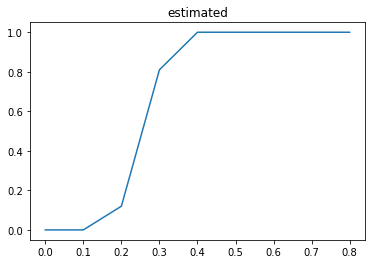

In [87]:
plt.plot(prob_space, estimated_prob)
plt.title("estimated")

# Visualization

In [131]:
@njit
def trial_plot(n, h, p, nodes, thresh):
    for _ in range(1):
        adjacency_matrix = np.zeros((n, n))
        history = np.zeros((n, n))
        for i in range(n):
            for j in range(i + 1, n):
                if np.random.random_sample() < p:
                    adjacency_matrix[i][j] = 1
                    history[i][j] = 1
        stabilized = False
        t = 1
        while not stabilized:
            t+=1
            stabilized = forward(adjacency_matrix, n, h, nodes, thresh,history,t)
    return history

In [161]:
h = 4
n = 400
prob_space = np.arange(0, 0.9, 0.1)
estimated_prob = np.zeros(len(prob_space,))
# find all triangles. Special treatment for k4
nodes = np.array(list(itertools.combinations([i for i in range(n)], 3)),dtype=int)
thresh = h * (h - 1) // 2
th = 0
for p in [0.1]:
    # mapping a complete graph to a list of coordinates
    # simulate ER graph generation
    plt.figure(figsize=(30,30))
    mat = trial_plot(n, h, p, nodes, thresh)
    plt.matshow(mat,fignum=1)
    plt.colorbar()
    plt.title(f"n={n}, h={h}, p={p}")
    plt.savefig(f"n={n}, h={h}, p={p}.png")


MemoryError: Unable to allocate 121. MiB for an array with shape (10586800, 3) and data type int32

In [95]:
# num_sim = 20
# estimated_prob = []

# h = 4
# n = 60
# prob_space = np.arange(0, 1, 0.01)
# nodes = np.array(list(itertools.combinations([i for i in range(n)], 3)),dtype=int)
# thresh = h * (h - 1) // 2
# out = trial_plot(30,n,h,0.25,estimated_prob,nodes,thresh)
# titled = [30, n, h, 0.25]

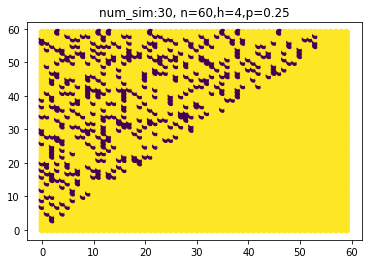

In [101]:
# def main():
#     numframes = 100
#     numpoints = 10
#     x = []
#     y = []
#     color = []
#     for i in range(len(out[0])):
#         for j in range(len(out[0])):
#             if out[0][i][j]==1:
#                 x.append(i)
#                 y.append(j)
#                 color.append(0)
#             else:
#                 x.append(i)
#                 y.append(j)
#                 color.append(1)
            
#     fig = plt.figure()
#     scat = plt.scatter(x, y, c=color)
#     plt.title(f"num_sim:{titled[0]}, n={n},h={h},p={titled[3]}")
#     ani = animation.FuncAnimation(fig, update_plot, frames=range(len(out)),
#                                   fargs=(out, scat, color),interval=160)
#     return ani

# def update_plot(i, data, scat, color):
#     pos = 0
#     for h in range(len(data[i])):
#         for j in range(len(data[i])):
#             if out[i][h][j]==1:
#                 color[pos] = 0
#             else:
#                 color[pos] =1
#             pos+=1
            
#     scat.set_array(np.array(color))
#     return scat,

# main()
